# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import authentic_performance as ap
from scipy.stats import uniform, norm
import networkx as nx
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch, os
from sklearn.model_selection import train_test_split
import torch_geometric.utils as utils
from torch.utils.data import DataLoader
import torch_geometric as pyg
from torch_geometric.nn import GCNConv
import pickle

# Analysis

## 1.0 Settings

In [3]:
def power_law(x, a=1):
    return (1/x)**a

l_ranking_performance = []

In [14]:
with open("data/synthetic-dataset/random-net-dumb-fraudster/test/0.0/G_0.pickle", "rb") as f:
        G = pickle.load(f)
N = G.number_of_nodes()
LEN_TRAIN_DATASET = len(list(os.walk("data/synthetic-dataset/random-net-no-fraudster/train"))[0][2])
LEN_TEST_DATASET = len(list(os.walk("data/synthetic-dataset/random-net-no-fraudster/test"))[0][2])
FRAUDSTER_INDEX = [x for x, y in nx.get_node_attributes(G, "fraud").items() if y][0]
print(f"N = {N}\nLEN_TRAIN_DATASET = {LEN_TRAIN_DATASET}\nLEN_TEST_DATASET = {LEN_TEST_DATASET}\nFRAUDSTER_INDEX = {FRAUDSTER_INDEX}")

N = 100
LEN_TRAIN_DATASET = 100
LEN_TEST_DATASET = 100
FRAUDSTER_INDEX = 50


In [15]:
def pick_randomNonFraudster():
    if FRAUDSTER_INDEX < int(N*0.7) and FRAUDSTER_INDEX > int(N*0.3):
        a = np.concatenate((np.arange(int(N*0.3), FRAUDSTER_INDEX), np.arange(FRAUDSTER_INDEX+1, int(N*0.7))))
    else:
        a = np.arange(int(N*0.3), int(N*0.7))
    return np.random.choice(a)

def plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, n_iter, window_size):
    plt.errorbar(x=l_fraud_probabilities,
             y=np.mean(a_random, axis=1),
             yerr=1.96*np.std(a_random, axis=1)/np.sqrt(n_iter),
             label='Random')
    plt.errorbar(x=l_fraud_probabilities,
                y=np.mean(a_fraudster, axis=1),
                yerr=1.96*np.std(a_fraudster, axis=1)/np.sqrt(n_iter),
                label='Fraudster')
    plt.plot(l_fraud_probabilities,[0.5]*len(l_fraud_probabilities), linestyle='--', color='grey')
    plt.title(f"Fraud score for a fraudster and a random node (n_iter={n_iter}, window_size={window_size})")
    plt.ylabel("Proportion of better neighboors")
    plt.xlabel("Fraud probability")
    plt.legend()

def save_results(a_fraudster, a_random, list_series, model_type):
    experiment = os.path.basename(globals()['__vsc_ipynb_file__']).split(".ipynb")[0]
    save_dir = os.path.join("results", experiment, model_type)
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, "fraudster_rankings.npy"), np.array([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series]))
    np.save(os.path.join(save_dir, "random_fraud_detection.npy"), a_random)
    np.save(os.path.join(save_dir, "fraudster_fraud_detection.npy"), a_fraudster)

## 1.1 Delta degrees ranking

### Ranking performance

In [6]:
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    ratings = ap.rate_deltaDegrees(G)
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")

l_ranking_performance.append({"network":"random",
                              "method":"delta degrees",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 700.1, std:50.7
Spearman correlation 	 mean:0.899, std:0.014


### Fraud sensitivity

In [167]:
l_fraudster_index = [20, 50, 80]
l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l3 = []
for fraudster_index in l_fraudster_index:
    l2 = []
    for fraud_proba in l_fraud_probabilities:
        l1 = []
        for _ in range(N_LOOPS):
            G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=fraudster_index,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=fraud_proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
            ratings = ap.rate_deltaDegrees(G)  # rating function
            l1.append(ratings)
        l2.append(np.stack(l1).mean(axis=0))
    l3.append(np.stack(l2))
output = np.stack(l3)

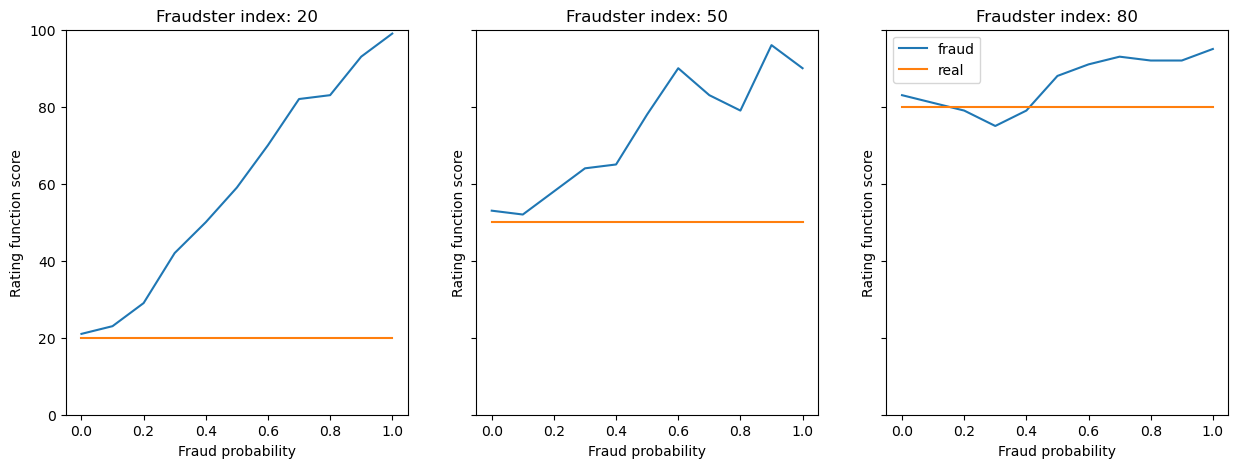

In [168]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
for i, fraudster_index in enumerate(l_fraudster_index):
    ax[i].plot(l_fraud_probabilities, np.nonzero((np.argsort(output[i, :, :], axis=1)==fraudster_index))[1], label="fraud")
    ax[i].plot(l_fraud_probabilities, [fraudster_index for _ in l_fraud_probabilities], label="real")
    ax[i].set_title(f"Fraudster index: {fraudster_index}")
    ax[i].set_xlabel("Fraud probability")
    ax[i].set_ylabel("Rating function score")
    ax[i].set_ylim(0,N)
plt.legend()

There is a linear relationship between the proportion of fraudulous links and the expected improvement of the rank which comes from the fact that the delta degree function is linear wrt the proportion of fraudulous links. Clearly the delta degree rating function is sensible to this kind of fraud.

### Fraud detection

In [169]:
window_size = 4

l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]

l_fraudster, l_random = [], []
for fraud_proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                    P,
                    distribution=DISTRIBUTION,
                    fraud=FRAUD,
                    fraudster_index=FRAUDSTER_INDEX,
                    fraudster_strength=FRAUDSTER_STRENGTH,
                    fraud_probability=fraud_proba,
                    strength_scheme=STRENGTH_SCHEME,
                    iterations=ITERATIONS,
                    decreasing_function=DECREASING_FUNCTION,
                    fraud_scheme=FRAUD_SCHEME)
        ratings = ap.rate_deltaDegrees(G)  # rating function
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

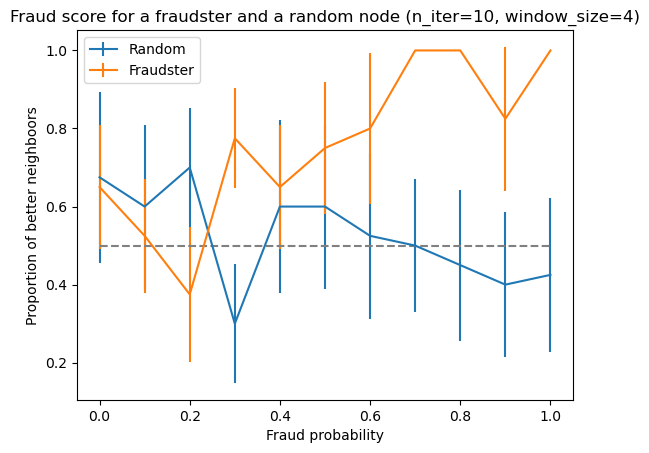

In [170]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Export results

In [171]:
experiment = os.path.basename(globals()['__vsc_ipynb_file__']).split(".ipynb")[0]
save_dir = os.path.join("results", experiment, "delta_degrees")
os.makedirs(save_dir, exist_ok=True)
np.save(os.path.join(save_dir, "fraudster_rankings.npy"), np.nonzero((np.argsort(output[1, :, :], axis=1)==FRAUDSTER_INDEX))[1])
np.save(os.path.join(save_dir, "random_fraud_detection.npy"), a_random)
np.save(os.path.join(save_dir, "fraudster_fraud_detection.npy"), a_fraudster)

In [172]:
del a_fraudster, a_random, l_fraud_probabilities, window_size, l_f, l_r, G

## 1.2 $f_{\alpha,t}$

### Training of $f_{\alpha,t}$
Optimization of parameters $\alpha$ and $t$ on fraudster free synthetic networks.

In [18]:
l_df = []
for i in range(LEN_TRAIN_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/train/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
        df = ap.convert_graphToDataFrame(G)
        l_df.append(df)
df = pd.concat(l_df)
X, y = torch.from_numpy(df[["wins","losses","draws"]].values).float(), torch.from_numpy(df["strength"].values).float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ap.WinLossDraw()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)


n_epoch = 100

l_param = []
l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
    l_train_loss.append(loss_train.item())
    l_param.append((model.alpha.item(), model.t.item()))
    with torch.no_grad():
        pred = model(X_test).flatten()
        loss_test = criterion(pred, y_test)
        l_test_loss.append(loss_test.item())

Text(0.5, 1.0, 'Offset t')

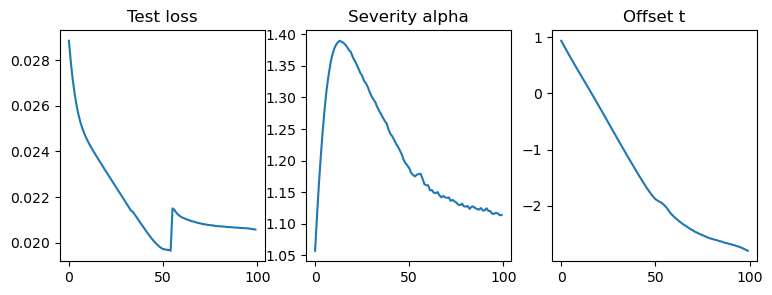

In [19]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(l_test_loss)
ax[0].set_title("Test loss")
ax[1].plot([x[0] for x in l_param])
ax[2].plot([x[1] for x in l_param])
ax[1].set_title("Severity alpha")
ax[2].set_title("Offset t")

### Ranking performance

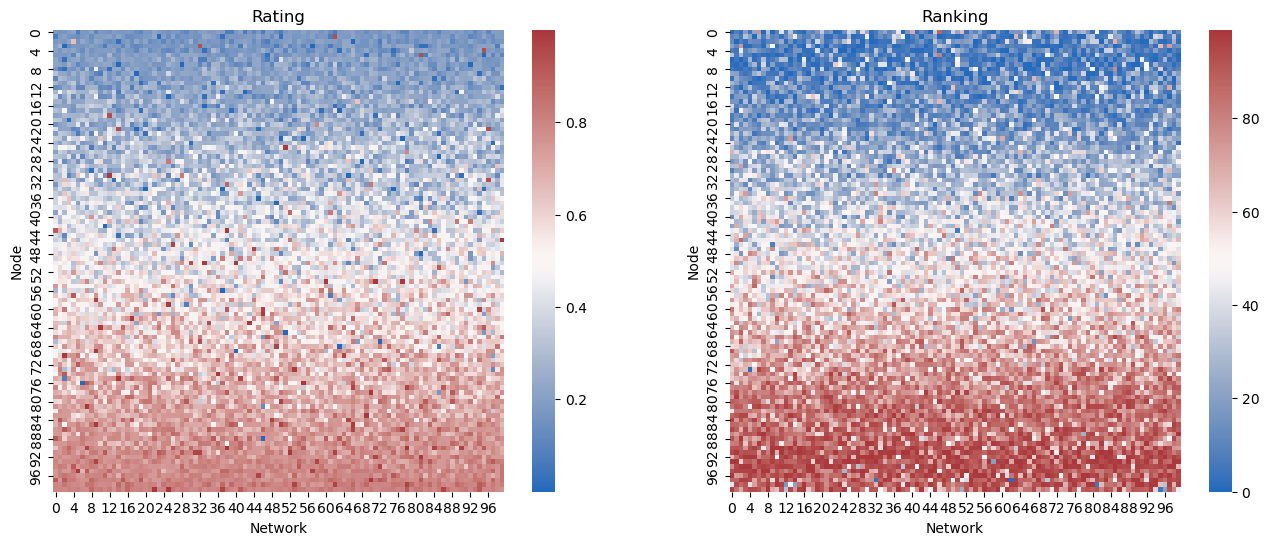

In [20]:
l_ratings, l_rankings = [], []
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    df = ap.convert_graphToDataFrame(G)
    ratings = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
    ranking = ap.argsort_robust(ratings)
    l_ratings.append(ratings)
    l_rankings.append(ranking)
    
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(np.stack(l_ratings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0]).set(xlabel='Network', ylabel='Node', title = "Rating");
sns.heatmap(np.stack(l_rankings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1]).set(xlabel='Network', ylabel='Node', title = "Ranking");

We can see that the WinLossDraw model performs well on average.

In [22]:
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for i in range(LEN_TEST_DATASET):
    with open(f"data/synthetic-dataset/random-net-no-fraudster/test/G_{i}.pickle", "rb") as f:
        G = pickle.load(f)
    t_ratings = model(torch.from_numpy(ap.convert_graphToDataFrame(G)[["wins", "losses", "draws"]].values))
    ratings = t_ratings.detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
l_ranking_performance.append({"network":"random",
                              "method":"f_alpha_t",
                              "kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                              "kendall_tau_distance (std)":np.std(a_ranking_distances),
                              "spearman_r (mean)":np.mean(a_spearman_r),
                              "spearman_r (std)":np.std(a_spearman_r)})

Kendall tau distance 	 mean: 706.7, std:67.4
Spearman correlation 	 mean:0.888, std:0.025


### Fraud sensitivity

In [177]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        l.append(df["pred_strength"].rank() -1)
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

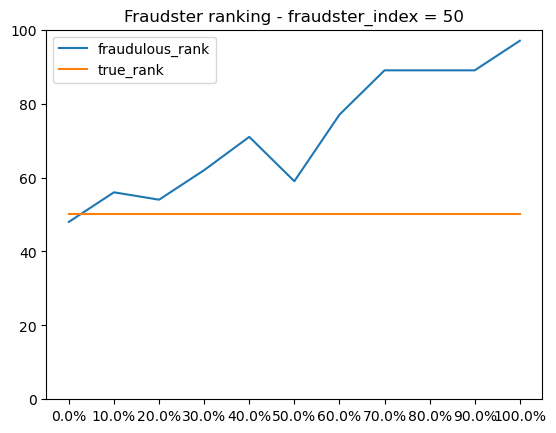

In [178]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

We can see that the function simple rating is fooled by the fraudster. It appears that the pattern is also linear.

### Fraud detection

In [179]:
window_size = 4

l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l_fraudster, l_random = [], []
for proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_index()["pred_strength"].values
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

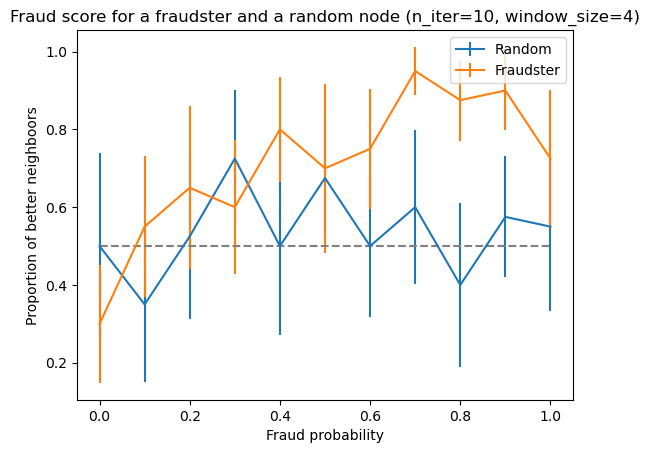

In [180]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Export results

In [181]:
save_results(a_fraudster, a_random, list_series, "f_alpha_t")
del a_fraudster, a_random, list_series, l_fraud_probabilities, window_size, l_f, l_r, G

## 1.3.A MLP rater

### Training

In [10]:
X, y = ap.generate_trainingData(generate_networkFraudFree, n=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [12]:
model = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

In [13]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

Text(0.5, 1.0, 'Test')

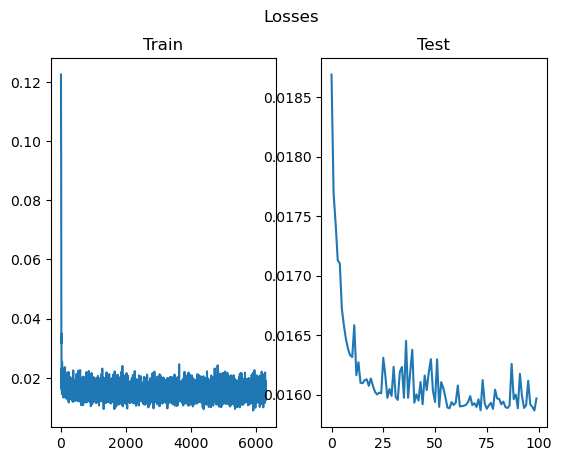

In [14]:
fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

### Ranking efficiency

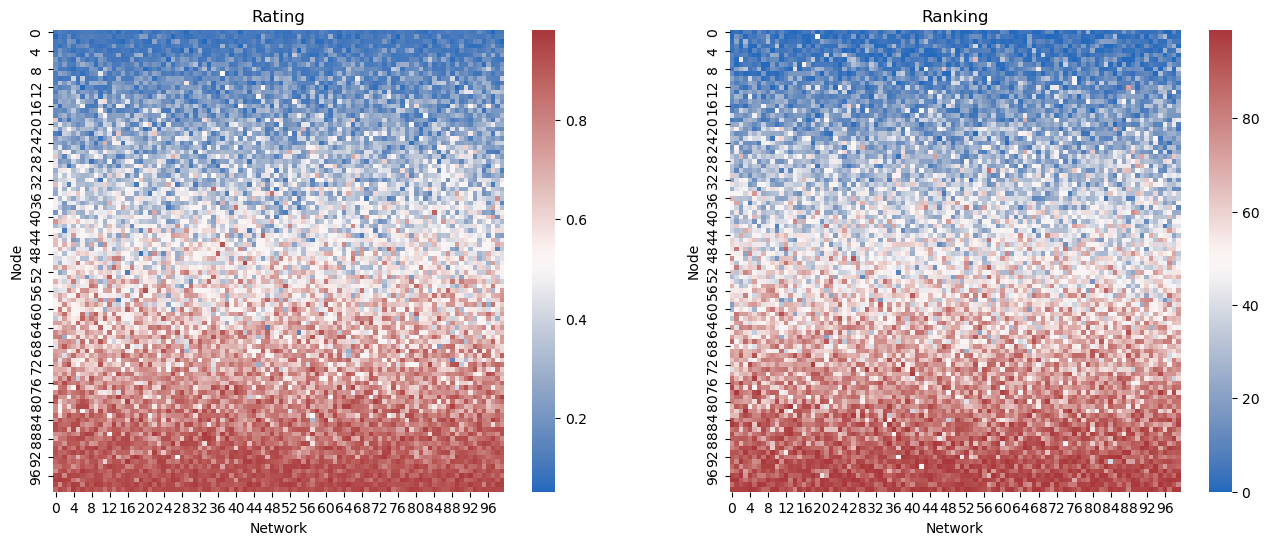

In [187]:
l_ratings, l_rankings = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    df = ap.convert_graphToDataFrame(G)
    ratings = model(torch.from_numpy(df[["wins", "losses", "draws"]].values).float()).flatten().detach().numpy()
    ranking = ap.argsort_robust(ratings)
    l_ratings.append(ratings)
    l_rankings.append(ranking)

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(np.stack(l_ratings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0]).set(xlabel='Network', ylabel='Node', title = "Rating");
sns.heatmap(np.stack(l_rankings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1]).set(xlabel='Network', ylabel='Node', title = "Ranking");

In [15]:
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for _ in range(N_LOOPS):
    G = generate_networkFraudFree()
    df = ap.convert_graphToDataFrame(G)
    ratings = model(torch.from_numpy(df[["wins", "losses", "draws"]].values).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
d_ranking_performance["MLP"]={"kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                        "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                        "spearman_r (mean)":np.mean(a_spearman_r),
                                        "spearman_r (std)":np.std(a_spearman_r)}

Kendall tau distance 	 mean: 625.3, std:55.1
Spearman correlation 	 mean:0.915, std:0.015


### Fraud sensitivity

In [189]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        l.append(df["pred_strength"].rank() -1)
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

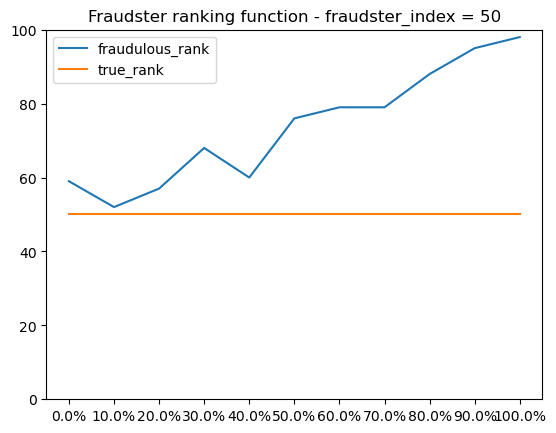

In [190]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

### Fraud detection

In [191]:
window_size = 4

l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l_fraudster, l_random = [], []
for proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        ratings = df.sort_index()["pred_strength"].values
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

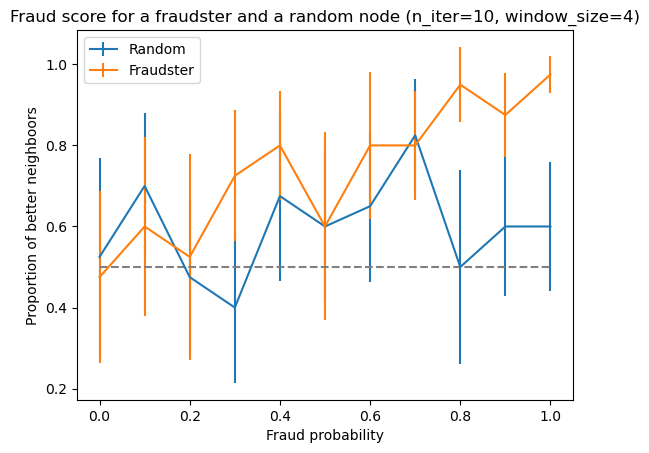

In [192]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Export results

In [193]:
save_results(a_fraudster, a_random, list_series, "mlp")
del a_fraudster, a_random, list_series, l_fraud_probabilities, window_size, l_f, l_r, G

## 1.3.B MLP rater with neighbor information

### Training

In [16]:
l_X, l_y = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    adjacency = nx.adjacency_matrix(G).todense()
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    l_X.append(X)
    l_y.append(y)
X = torch.tensor(np.concatenate(l_X), dtype=torch.float)
y = torch.tensor(np.concatenate(l_y), dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

/tmp/ipykernel_11859/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_11859/1815881219.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_11859/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_11859/1815881219.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_11859/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipyker

In [17]:
model = MLP(4, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Text(0.5, 1.0, 'Test')

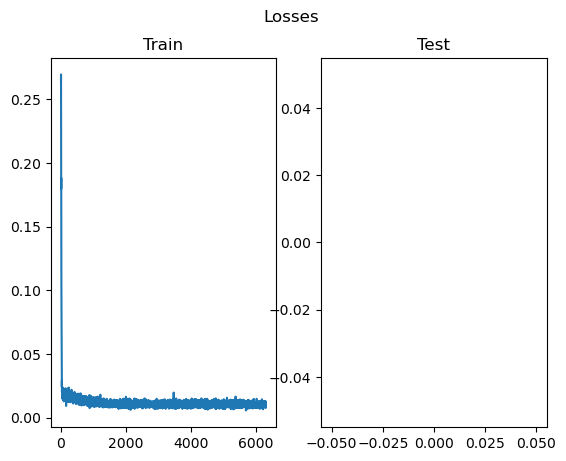

In [18]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

### Ranking efficiency (compared with standard MLP)
Comparison with standard MLP, trained on same input data (except neigbourhood information) \
The two confidence intervals don't overlap so we can say **there is an interest in looking at topological information**

/tmp/ipykernel_13653/1596970372.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_13653/1596970372.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_13653/1596970372.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_13653/1596970372.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_13653/1596970372.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/i

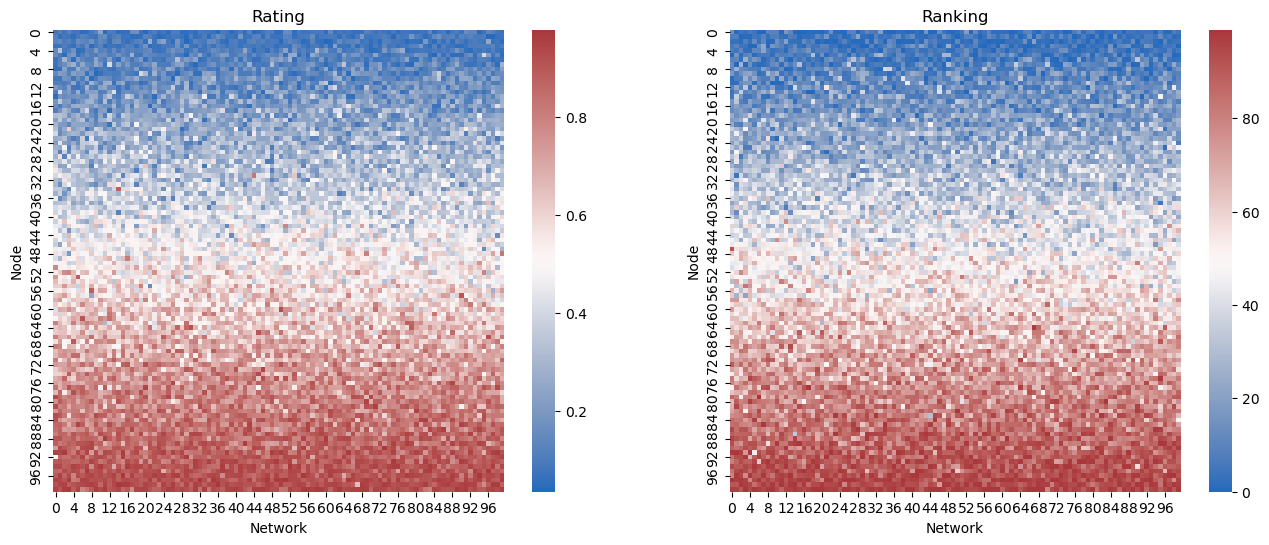

In [93]:
l_ratings, l_rankings = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    adjacency = nx.adjacency_matrix(G).todense();
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    ratings = model(torch.from_numpy(X).float()).flatten().detach().numpy()
    ranking = ap.argsort_robust(ratings)
    l_ratings.append(ratings)
    l_rankings.append(ranking)

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(np.stack(l_ratings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0]).set(xlabel='Network', ylabel='Node', title = "Rating");
sns.heatmap(np.stack(l_rankings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1]).set(xlabel='Network', ylabel='Node', title = "Ranking");

In [19]:
model_standard = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_standard.parameters(), lr=1e-3)

Text(0.5, 1.0, 'Test')

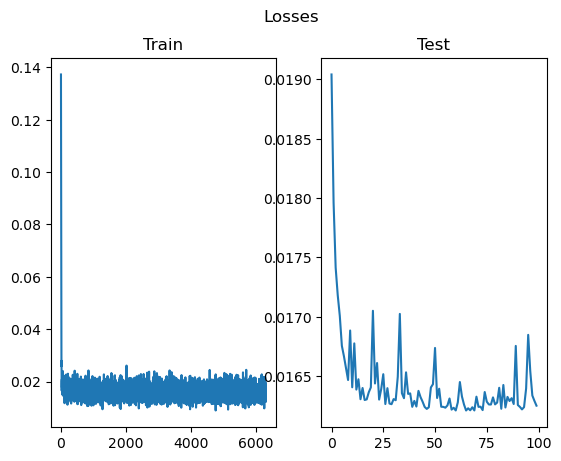

In [20]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model_standard.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model_standard(data[:,:3]).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model_standard.eval()
    pred = model_standard(X_test[:,:3]).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

In [21]:
l_ranking_distances = []
l_spearman_r = []
l_ranking_distances_standard = []
l_spearman_r_standard = []
a_ranking_true = np.arange(N)
for _ in range(N_LOOPS):
    G = generate_networkFraudFree()
    adjacency = nx.adjacency_matrix(G).todense();
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    
    # mlp with neighbourhood information
    ratings = model(torch.from_numpy(X).float()).flatten().detach().numpy()
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    # if np.isnan(spearman_r.correlation):
    #     break
    l_spearman_r.append(spearman_r.correlation)
    
    # standard mlp
    ratings_standard = model_standard(torch.from_numpy(X[:,:3]).float()).flatten().detach().numpy()
    a_rankings_standard = ap.argsort_robust(ratings_standard)
    kendall_tau_distance_standard = ap.kendall_tauDistance(a_ranking_true, a_rankings_standard)
    l_ranking_distances_standard.append(kendall_tau_distance_standard)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r_standard = scipy.stats.spearmanr(ratings_standard, a_strengths)
    l_spearman_r_standard.append(spearman_r_standard.correlation)


a_ranking_distances = np.array(l_ranking_distances)
a_ranking_distances_standard = np.array(l_ranking_distances_standard)
a_spearman_r = np.array(l_spearman_r)
a_spearman_r_standard = np.array(l_spearman_r_standard)

/tmp/ipykernel_11859/3679294510.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_11859/3679294510.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_11859/3679294510.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_11859/3679294510.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_11859/3679294510.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/i

In [22]:
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
print(f"Kendall tau distance (standard) \t mean: {np.mean(a_ranking_distances_standard):.1f}, std:{np.std(a_ranking_distances_standard):.1f}\nSpearman correlation (standard) \t mean:{np.mean(a_spearman_r_standard):.3f}, std:{np.std(a_spearman_r_standard):.3f}")

d_ranking_performance["MLP_neighbourhood"]={"kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                        "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                        "spearman_r (mean)":np.mean(a_spearman_r),
                                        "spearman_r (std)":np.std(a_spearman_r)}

Kendall tau distance 	 mean: 492.1, std:45.3
Spearman correlation 	 mean:0.947, std:0.010
Kendall tau distance (standard) 	 mean: 634.8, std:51.2
Spearman correlation (standard) 	 mean:0.912, std:0.014


### Fraud sensitivity

In [202]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        l.append(s.rank()-1)
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

/tmp/ipykernel_9557/2546929025.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_9557/2546929025.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_9557/2546929025.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_9557/2546929025.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_9557/2546929025.py:17: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/i

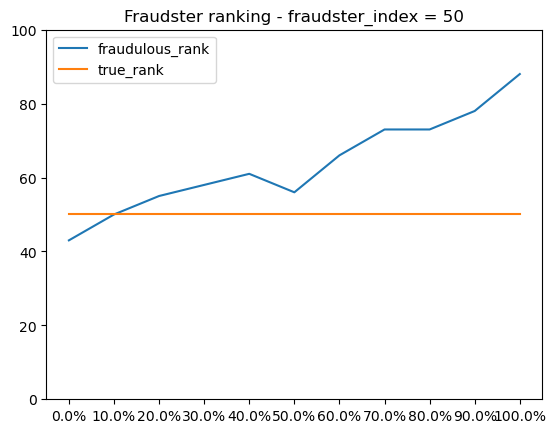

In [203]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

### Fraud detection

In [204]:
window_size = 4

l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l_fraudster, l_random = [], []
for proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        ratings = s.values
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

/tmp/ipykernel_9557/4112252034.py:19: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_9557/4112252034.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_9557/4112252034.py:19: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_9557/4112252034.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_9557/4112252034.py:19: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/i

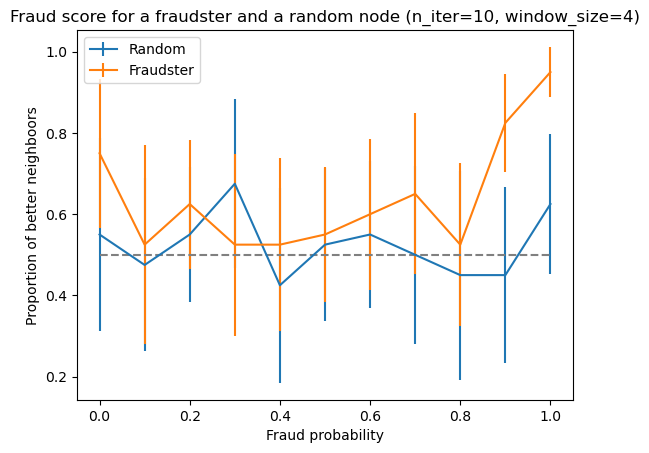

In [205]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Bonus
We can investigate this model to understand what is the impact of the strength of the neighboorhood on the rating. We see that a stronger neighboorhood leads to higher rating, for all wins/losses profiles.

Text(0.5, 1.0, 'Impact of neighboorhood performance on rating')

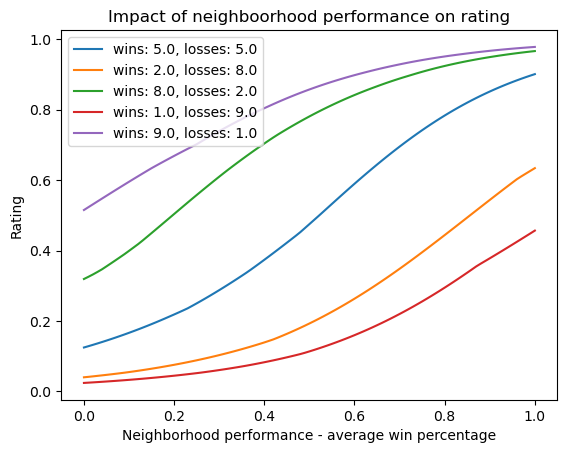

In [206]:
for wins, losses in [(5.,5.),  (2.,8.), (8.,2.), (1.,9.), (9.,1.)]:
    t1 = torch.permute(torch.tensor([wins, losses, 0.], requires_grad=False).repeat(101,1), (1,0))
    t2 = torch.permute(torch.linspace(0,1,101).view(101,1), (1,0))
    data = torch.permute(torch.concat((t1,t2)), (1,0))
    plt.plot(data[:,3], model(data).detach().numpy(), label=f"wins: {wins}, losses: {losses}")
plt.legend()
plt.xlabel("Neighborhood performance - average win percentage")
plt.ylabel("Rating")
plt.title("Impact of neighboorhood performance on rating")

### Export results

In [207]:
save_results(a_fraudster, a_random, list_series, "mlp_neighbourhood_info")
del a_fraudster, a_random, list_series, l_fraud_probabilities, window_size, l_f, l_r, G

## 1.4 PageRank

### Ranking efficiency

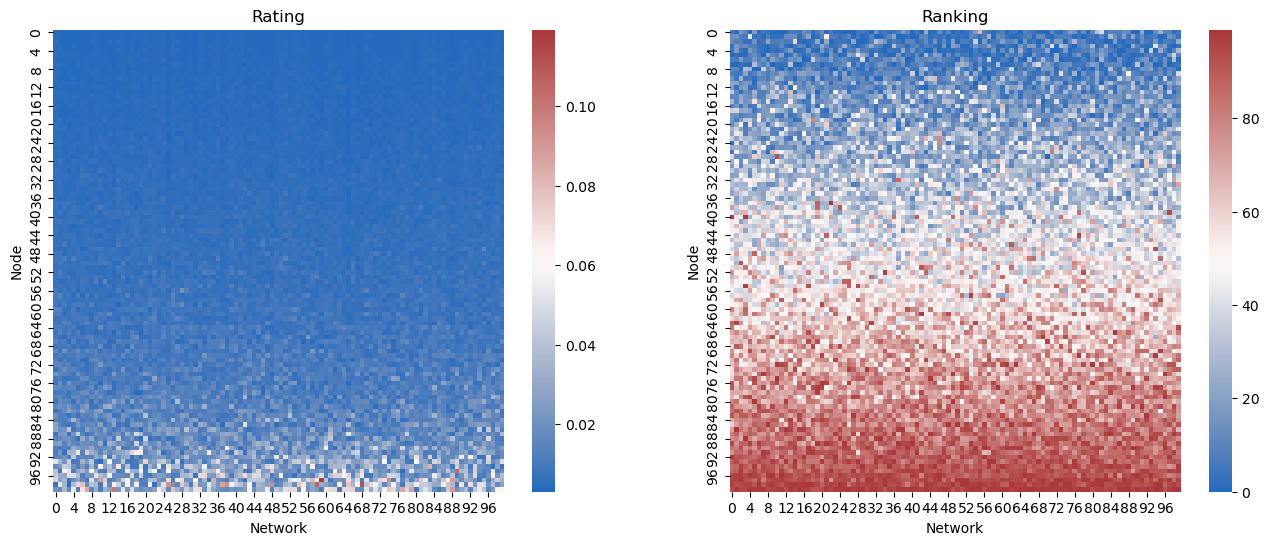

In [208]:
l_ratings, l_rankings = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    pr = nx.pagerank(G)
    ratings = np.array(list(pr.values()))
    ranking = ap.argsort_robust(ratings)
    l_ratings.append(ratings)
    l_rankings.append(ranking)

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(np.stack(l_ratings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0]).set(xlabel='Network', ylabel='Node', title = "Rating");
sns.heatmap(np.stack(l_rankings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1]).set(xlabel='Network', ylabel='Node', title = "Ranking");

In [23]:
l, l_alpha = [], []
a_ranking_true = np.arange(N)
alpha_values = list(np.linspace(0.1, 0.9, 9)) + [0.99, 0.999, 1.]
for alpha in alpha_values:
    for _ in range(N_LOOPS):
        G = generate_networkFraudFree()
        pr = nx.pagerank(G, alpha=alpha, max_iter=10000)
        ratings = np.array(list(pr.values()))
        a_rankings = ap.argsort_robust(ratings)
        l.append(ap.kendall_tauDistance(a_ranking_true, a_rankings))
    a_ranking_distances = np.array(l)
    l_alpha.append((np.mean(a_ranking_distances), np.std(a_ranking_distances)))

Text(0, 0.5, 'kendall tau distance (to best permutation)')

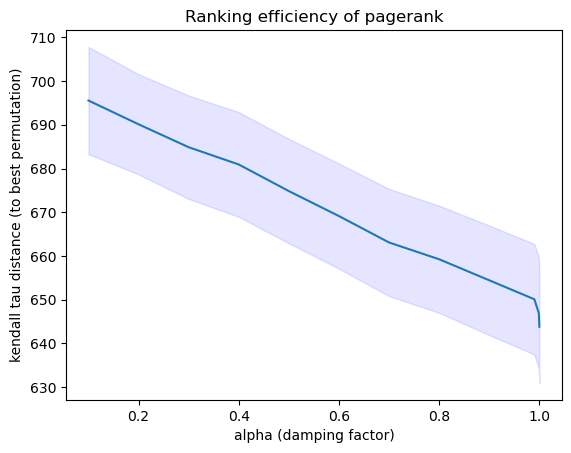

In [24]:
y = [x[0] for x in l_alpha]
plt.plot(alpha_values, y)
ci = 1.96 * np.array([x[1]/np.sqrt(N_LOOPS) for x in l_alpha])
plt.fill_between(alpha_values, (y-ci), (y+ci), color='b', alpha=.1)
plt.title("Ranking efficiency of pagerank")
plt.xlabel("alpha (damping factor)")
plt.ylabel("kendall tau distance (to best permutation)")

Interestingly, the pagerank does not achieve better performance on on random network than an MLP, and is far from an MLP with neighbourhood. This is surprising because the immediate neighbourhood information made quite an impact when considering MLPs, even with this information restricted to direct neighbours. Since pagerank can leverage all orders of neighbourhoods, it would perhaps be expected that it had more expressive power however it seems not to be the case. It also seems that the lowest the damping factor, the better the ranking efficiency which indicates that longer dependencies are of interest.

In [25]:
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for _ in range(N_LOOPS):
    G = generate_networkFraudFree()
    pr = nx.pagerank(G)
    ratings = np.array(list(pr.values()))
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
    
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
d_ranking_performance["PageRank"]={"kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                        "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                        "spearman_r (mean)":np.mean(a_spearman_r),
                                        "spearman_r (std)":np.std(a_spearman_r)}

Kendall tau distance 	 mean: 614.5, std:58.4
Spearman correlation 	 mean:0.916, std:0.016


### Fraud sensitivity

In [212]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        pr = nx.pagerank(G)
        s = pd.Series(pr)
        l.append(s.rank()-1)
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

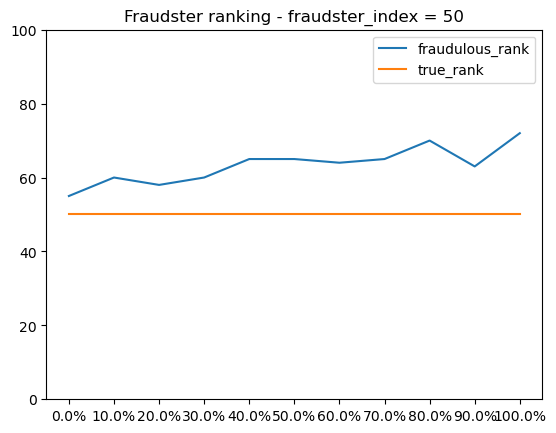

In [213]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

### Fraud detection

In [214]:
window_size = 4

l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l_fraudster, l_random = [], []
for proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        pr = nx.pagerank(G)
        s = pd.Series(pr).sort_index()
        ratings = s.values
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

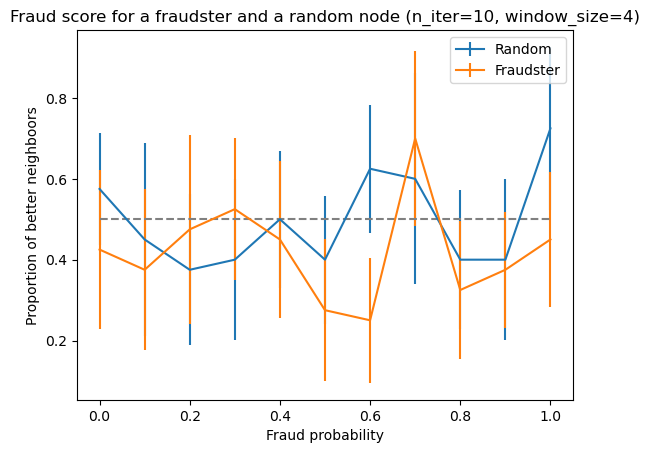

In [215]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Export results

In [216]:
save_results(a_fraudster, a_random, list_series, "pagerank")
del a_fraudster, a_random, list_series, l_fraud_probabilities, window_size, l_f, l_r, G

## 1.5 GNN

Rater framed as a node level regression task

### 1.5.1 GCN

#### Training

In [26]:
class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_features)
        # self.conv2 = GCNConv(hidden_features, hidden_features)
        self.conv_out = GCNConv(hidden_features, 1)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.nn.ReLU()(self.conv1(x, edge_index))
        # x = torch.nn.ReLU()(self.conv2(x, edge_index))
        x = self.conv_out(x, edge_index)
        return torch.nn.Sigmoid()(x)

In [27]:
def convert_nxToPyGData(G):
    data = pyg.utils.convert.from_networkx(G)
    data.id = torch.tensor(list(G.nodes()))
    data.x = torch.permute(torch.concat((pyg.utils.degree(data.edge_index[0], num_nodes=data.num_nodes).view(1,-1),
                                        pyg.utils.degree(data.edge_index[1], num_nodes=data.num_nodes).view(1,-1))),(1,0)).float()
    data.y = data.strength.float()
    return data

In [28]:
dataset = []
for _ in range(100):
    G = generate_networkFraudFree()
    data = convert_nxToPyGData(G)
    dataset.append(data)
dataloader_train = pyg.loader.DataLoader(dataset[:int(len(dataset)*0.8)], batch_size=10, shuffle=True)
dataloader_test = pyg.loader.DataLoader(dataset[int(len(dataset)*0.8):], batch_size=10, shuffle=True)

In [29]:
model = GCN(in_features=data.x.shape[1], hidden_features=100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

GCN(
  (conv1): GCNConv(2, 100)
  (conv_out): GCNConv(100, 1)
)

In [30]:
def evaluate():
    loss = 0
    for data in dataloader_test:
        output = model(data).flatten()
        loss += torch.nn.MSELoss(reduction='sum')(output, data.y)
    return (loss / (len(dataloader_test.sampler)*N)).item()

In [31]:
n_epochs = 100

l_train_loss, l_test_loss = [], []
for epoch in range(n_epochs):
    # print(f"Epoch {epoch+1}")
    for data in dataloader_train:
        optimizer.zero_grad()
        output = model(data).flatten()
        loss_train = criterion(output, data.y)
        loss_train.backward()
        optimizer.step()
        l_train_loss.append(loss_train.item())
    loss_test = evaluate()
    l_test_loss.append(loss_test)

Text(0.5, 1.0, 'Test')

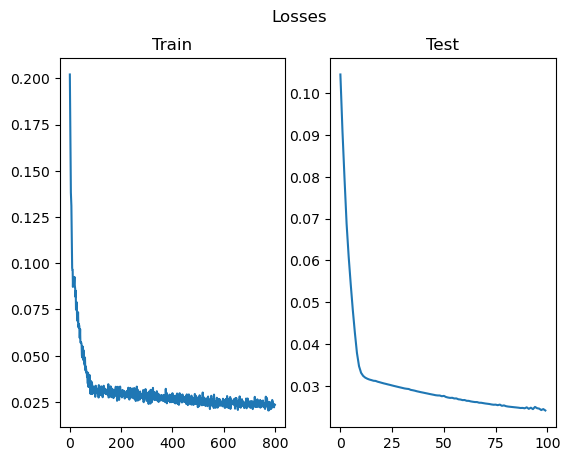

In [32]:
fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

#### Ranking efficiency

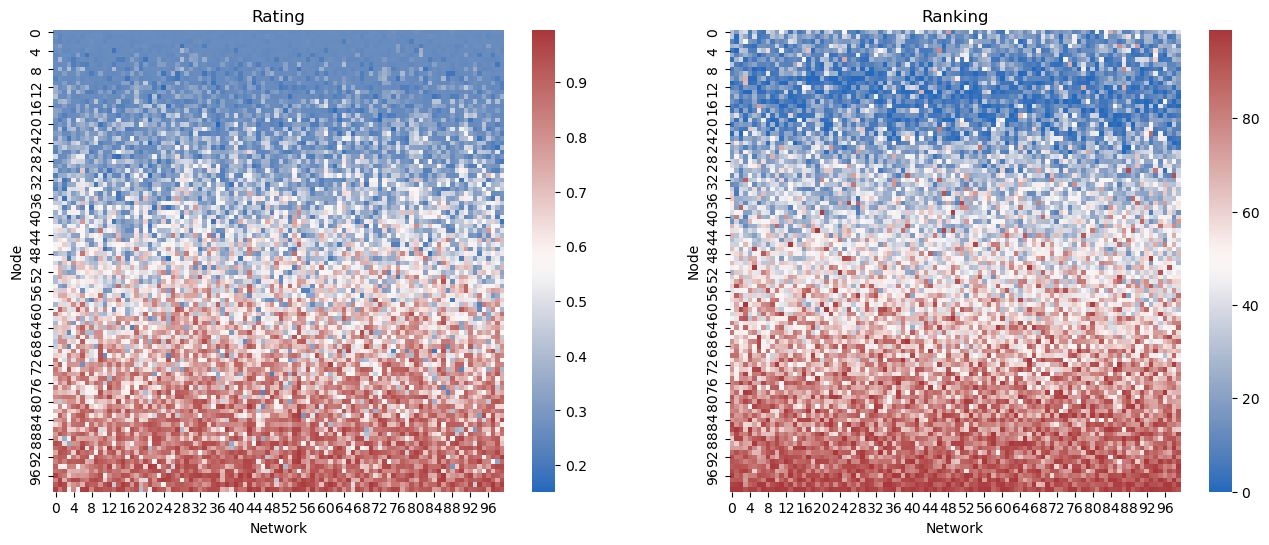

In [224]:
l_ratings, l_rankings = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    data = convert_nxToPyGData(G)
    ratings = model(data).flatten()[torch.argsort(data.id)].detach().numpy()  # reordering so that nodes are ordered by their id
    ranking = ap.argsort_robust(ratings)
    l_ratings.append(ratings)
    l_rankings.append(ranking)

fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(np.stack(l_ratings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[0]).set(xlabel='Network', ylabel='Node', title = "Rating");
sns.heatmap(np.stack(l_rankings, axis=1),
            cmap=sns.color_palette("vlag", as_cmap=True), ax=ax[1]).set(xlabel='Network', ylabel='Node', title = "Ranking");

In [33]:
l_ranking_distances = []
l_spearman_r = []
a_ranking_true = np.arange(N)
for _ in range(N_LOOPS):
    G = generate_networkFraudFree()
    data = convert_nxToPyGData(G)
    ratings = model(data).flatten()[torch.argsort(data.id)].detach().numpy()  # reordering so that nodes are ordered by their id
    a_rankings = ap.argsort_robust(ratings)
    kendall_tau_distance = ap.kendall_tauDistance(a_ranking_true, a_rankings)
    l_ranking_distances.append(kendall_tau_distance)
    a_strengths = pd.Series(nx.get_node_attributes(G, "strength")).sort_index().values
    spearman_r = scipy.stats.spearmanr(ratings, a_strengths)
    l_spearman_r.append(spearman_r.correlation)
a_ranking_distances = np.array(l_ranking_distances)
a_spearman_r = np.array(l_spearman_r)
print(f"Kendall tau distance \t mean: {np.mean(a_ranking_distances):.1f}, std:{np.std(a_ranking_distances):.1f}\nSpearman correlation \t mean:{np.mean(a_spearman_r):.3f}, std:{np.std(a_spearman_r):.3f}")
d_ranking_performance["GCN"]={"kendall_tau_distance (mean)":np.mean(a_ranking_distances),
                                        "kendall_tau_distance (std)":np.std(a_ranking_distances),
                                        "spearman_r (mean)":np.mean(a_spearman_r),
                                        "spearman_r (std)":np.std(a_spearman_r)}

Kendall tau distance 	 mean: 805.2, std:103.4
Spearman correlation 	 mean:0.868, std:0.033


#### Fraud sensitivity

In [226]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
list_series_std = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        data = convert_nxToPyGData(G)
        s = pd.Series((model(data).flatten()[torch.argsort(data.id)]).detach().numpy())
        l.append(s)
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    list_series_std.append(pd.concat(l, axis=1).std(axis=1))

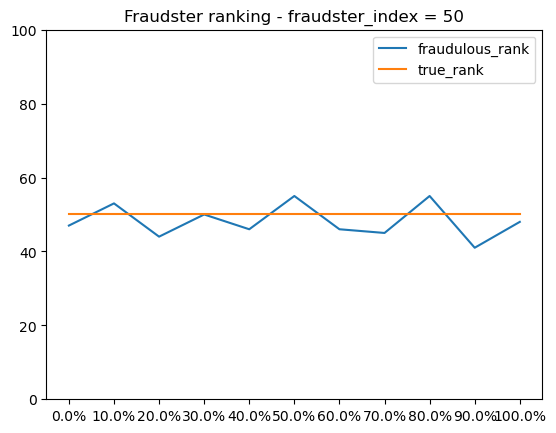

In [227]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

### Fraud detection

In [228]:
window_size = 4


l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l_fraudster, l_random = [], []
for proba in l_fraud_probabilities:
    l_f, l_r = [], []
    for _ in range(N_LOOPS):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        data = convert_nxToPyGData(G)
        s = pd.Series((model(data).flatten()[torch.argsort(data.id)]).detach().numpy())
        ratings = s.sort_index().values
        ranking = ap.argsort_robust(ratings)
        random_node = pick_randomNonFraudster()
        l_f.append(ap.score_fraud(G, ranking, window_size, FRAUDSTER_INDEX))
        l_r.append(ap.score_fraud(G, ranking, window_size, random_node))
    l_fraudster.append(l_f)
    l_random.append(l_r)

a_random = np.array(l_random)
a_fraudster = np.array(l_fraudster)

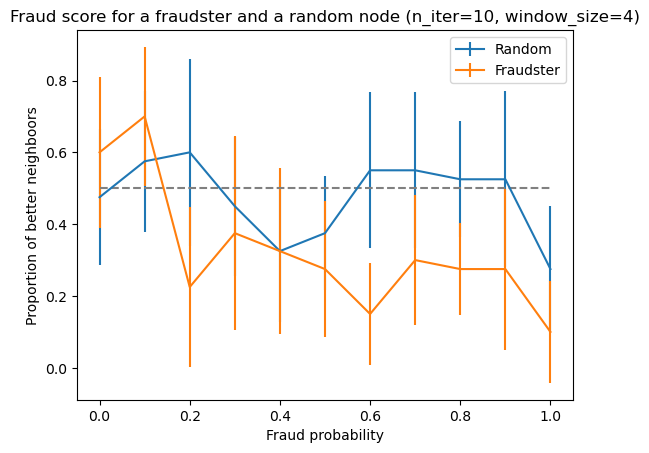

In [229]:
plot_fraudScores(a_random, a_fraudster, l_fraud_probabilities, N_LOOPS, window_size)

### Export results

In [230]:
save_results(a_fraudster, a_random, list_series, "gnn")
del a_fraudster, a_random, list_series, l_fraud_probabilities, window_size, l_f, l_r, G

# Staging

# <>